# Circuit function analytics: Stats summarizing behavior (precision, sensitivity, response time...)



In [15]:

from functools import partial
import numpy as np
import pandas as pd
import jax.numpy as jnp
import jax
jax.config.update('jax_platform_name', 'cpu')
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import bioreaction
from bioreaction.simulation.med_sim import get_int_med_model, MedSimParams, MedSimInternalState
from bioreaction.model.data_tools import construct_model_fromnames
from bioreaction.simulation.basic_sim import basic_de_sim, convert_model, BasicSimParams, BasicSimState


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


from src.utils.results.analytics.naming import get_analytics_types_all, get_true_names_analytics
from src.utils.results.analytics.timeseries import generate_analytics
from src.utils.misc.type_handling import flatten_listlike
from src.utils.signal.signals_new import SignalFuncs

In [16]:

def update_model_rates(model, a=None, d=None, ka=None, kd=None):
    for i, r in enumerate(model.reactions):
        if not r.input:  # 0 -> RNA
            if a is not None:
                model.reactions[i].forward_rate = a[model.species.index(
                    r.output[0])]
                model.reactions[i].reverse_rate = 0
        elif not r.output:  # RNA -> 0
            if d is not None:
                model.reactions[i].forward_rate = d[model.species.index(
                    r.input[0])]
                model.reactions[i].reverse_rate = 0
        else:
            if ka is not None:
                model.reactions[i].forward_rate = ka[model.species.index(r.input[0]),
                                                    model.species.index(r.input[1])]
            if kd is not None:
                model.reactions[i].reverse_rate = kd[model.species.index(r.input[0]),
                                                    model.species.index(r.input[1])]
    return model


### Define parameters

In [17]:
num_species = 3
input_species_idx = 0
output_species_idx = 1


med_model = bioreaction.templates.generate_rnabinding_medsim(
    num_species=num_species,
    a=np.ones(num_species), d=np.ones(num_species**2), 
    ka=np.ones((num_species, num_species)),
    kd=np.ones((num_species, num_species)),
    impulse_idx=input_species_idx
)

Keq = np.array(
    [[1, 2, 1],
     [2, 1, 0.5],
     [1, 0.5, 2]]
)
# From src/utils/common/configs/RNA_circuit/molecular_params.json
a=np.ones(num_species) * 0.08333
d=np.ones(len(med_model.species)) * 0.0008333
ka=np.ones_like(Keq)
kd=ka/Keq

med_model = update_model_rates(med_model, a=a, d=d, ka=ka, kd=kd)

t0 = 0 
t1 = 100
dt0 = 0.1
t = np.arange(t0, t1/dt0) * dt0
t_sig = t1/2
target = 100
baseline = 120
overshoot = 10
overshoot_height = target + 10

In [18]:

s0 = np.concatenate([np.array([1.0, 1.0, 1.0]), np.zeros(len(med_model.species[num_species:]))])

# impulse = Impulse(target=med_model.species[:num_species][input_species_idx], delta_target=20, time=100.0, impulse_width=0.0)
med_model.impulses = []
poiss_simmed = jnp.zeros(len(med_model.reactions))
brown_simmed = jnp.zeros(len(med_model.reactions))

# Making the params for the simulation, how things are simutated and for how long.
int_med_params = MedSimParams(delta_t= 0.01, t_start=0.0, t_end = 1000.0, poisson_sim_reactions=poiss_simmed, brownian_sim_reaction=brown_simmed)
int_med_model = get_int_med_model(med_model)
int_med_state = MedSimInternalState(concentrations=s0, other_factors=jnp.zeros(len(med_model.other_factors)))

### Make some fake signals

Text(0.5, 1.0, 'Toy input signals')

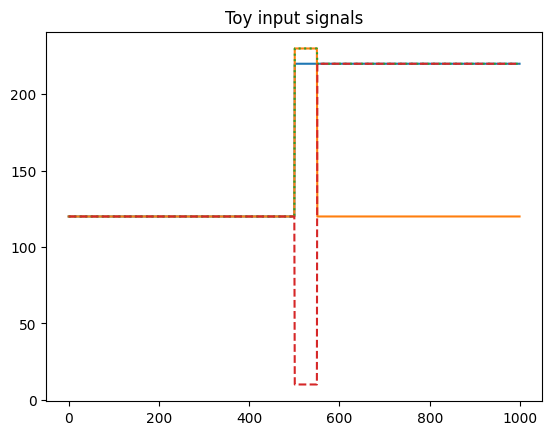

In [19]:
i = 0
plt.plot(np.array(SignalFuncs.step_function_integrated(t, t_sig + i, target=target + i)) + baseline)
plt.plot(SignalFuncs.step_function_integrated(t, t_sig + i, target=overshoot_height + i) - 
         SignalFuncs.step_function_integrated(t, t_sig + i + overshoot/2, target=overshoot_height + i) + baseline)
plt.plot(SignalFuncs.step_function_integrated(t, t_sig + i, target=target + i) + 
         SignalFuncs.step_function_integrated(t, t_sig + i, target=overshoot + i) - 
         SignalFuncs.step_function_integrated(t, t_sig + i + overshoot/2, target=overshoot + i) + baseline, ':')

plt.plot(
    SignalFuncs.step_function_integrated(t, t_sig + i, target=- (overshoot_height + i)) +
    SignalFuncs.step_function_integrated(t, t_sig + i + overshoot/2, target= 2 * target + overshoot + i) + baseline,
    '--'
)
plt.title('Toy input signals')

In [20]:

signal_onehot = 1 * \
    np.array([f == med_model.species[input_species_idx]
             for f in med_model.species])

data = np.asarray([
    SignalFuncs.step_function_integrated(t, t_sig + i, target=target + i) +
    SignalFuncs.step_function_integrated(t, t_sig + i, target=overshoot) -
    SignalFuncs.step_function_integrated(t, t_sig + i + overshoot/2, target=overshoot) for i in range(len(med_model.species))]) + baseline
data[input_species_idx] = np.array(
    SignalFuncs.step_function_integrated(t, t_sig, target=target)) + baseline
data[2] = np.array(SignalFuncs.step_function_integrated(
    t, t_sig + 2, target=target + 2)) + baseline
data[3] = baseline
data[4] = np.asarray(
    SignalFuncs.step_function_integrated(t, t_sig + 4, target=- (overshoot_height + 4)) +
    SignalFuncs.step_function_integrated(t, t_sig + 4 + overshoot/2, target= 2 * target + overshoot + 4)) + baseline
ref_circuit_data = np.asarray([
    SignalFuncs.step_function_integrated(t, t_sig + i * 2, target=target + i * 2) +
    SignalFuncs.step_function_integrated(t, t_sig + i * 2, target=overshoot) -
    SignalFuncs.step_function_integrated(t, t_sig + i * 2 + overshoot/2, target=overshoot) for i in range(len(med_model.species))]) + baseline
ref_circuit_data[input_species_idx] = np.array(
    SignalFuncs.step_function_integrated(t, t_sig, target=target)) + baseline
ref_circuit_data[2] = np.array(
    SignalFuncs.step_function_integrated(t, t_sig + 2, target=target + 2)) + baseline
ref_circuit_data[3] = baseline
ref_circuit_data[4] = np.asarray(
    SignalFuncs.step_function_integrated(t, t_sig + 4 * 2, target=- (overshoot_height + 4 * 2)) +
    SignalFuncs.step_function_integrated(t, t_sig + 4 * 2 + overshoot/2, target= 2 * target + overshoot +  4 * 2)) + baseline

signal_onehot_expanded = (np.ones_like(
    data) * np.expand_dims(signal_onehot, axis=1))
data_sig_rev = data * (signal_onehot_expanded == 0)*1 + ((data[input_species_idx].max(
    ) + data[input_species_idx].min()) - data) * signal_onehot_expanded
ref_circuit_data_sig_rev = ref_circuit_data * (signal_onehot_expanded == 0)*1 + ((ref_circuit_data[input_species_idx].max(
    ) + ref_circuit_data[input_species_idx].min()) - ref_circuit_data) * signal_onehot_expanded

batch_data = np.concatenate(np.expand_dims([
    data,
    (data.max() + data.min()) - data,
    data_sig_rev,
    (data_sig_rev.max() + data_sig_rev.min()) - data_sig_rev
    # data_rev * (signal_onehot_expanded == 0)*1 + data * signal_onehot_expanded,
], axis=0), axis=0
)
batch_ref_data = np.concatenate(np.expand_dims([
    ref_circuit_data,
    (ref_circuit_data.max() + ref_circuit_data.min()) - ref_circuit_data,
    ref_circuit_data_sig_rev,
    (ref_circuit_data_sig_rev.max() + ref_circuit_data_sig_rev.min()) - ref_circuit_data_sig_rev,
], axis=0), axis=0
)

vmap_gen_analytics = jax.vmap(partial(generate_analytics, time=t, labels=med_model.species,
                                      signal_onehot=signal_onehot,
                                      signal_time=t_sig))
analytics = {k: np.array(v) for k, v in
             vmap_gen_analytics(
                 batch_data, ref_circuit_data=batch_ref_data).items()
             }


In [21]:

def get_peaks(initial_steady_states, final_steady_states, maxa, mina):
    return jnp.where(
        (initial_steady_states > mina) &
        (final_steady_states > mina) &
        ((final_steady_states > maxa) ==
         (initial_steady_states > final_steady_states)),
        mina, maxa
    )


def calculate_precision(output_diff, starting_states, signal_diff, signal_0) -> jnp.ndarray:
    denom = jnp.where(signal_0 != 0, signal_diff / signal_0, 1)
    numer = jnp.where((starting_states != 0).astype(int),
                      output_diff / starting_states, 1)
    precision = jnp.absolute(jnp.divide(
        numer, denom))
    return jnp.divide(1, precision)


def get_precision(signal_idx: int, starting_states, steady_states):
    if signal_idx is None:
        return None
    signal_0 = starting_states[signal_idx]
    signal_1 = steady_states[signal_idx]

    signal_diff = signal_1 - signal_0
    output_diff = steady_states - starting_states

    return calculate_precision(output_diff, starting_states, signal_diff, signal_0)


def calculate_sensitivity(output_diff, starting_states, signal_diff, signal_0) -> jnp.ndarray:
    denom = jnp.where(signal_0 != 0, signal_diff / signal_0, np.inf)
    numer = jnp.where((starting_states != 0).astype(int),
                      output_diff / starting_states, np.inf)
    return jnp.absolute(jnp.divide(
        numer, denom))


def get_sensitivity(signal_idx: int, starting_states, peaks):
    if signal_idx is None:
        return None
    signal_1 = peaks[signal_idx]
    signal_0 = starting_states[signal_idx]

    output_diff = peaks - starting_states
    signal_diff = signal_1 - signal_0

    return calculate_sensitivity(output_diff, starting_states, signal_diff, signal_0)


In [68]:
(initial_steady_states > mina)

array([[False, False, False, False,  True, False, False, False, False],
       [ True,  True,  True, False,  True,  True,  True,  True,  True],
       [ True, False, False, False,  True, False, False, False, False],
       [False,  True,  True, False,  True,  True,  True,  True,  True]])

In [70]:

initial_steady_states = batch_data[:, :, 0]
final_steady_states = batch_data[:, :, -1]
maxa = batch_data.max(axis=2)
mina = batch_data.min(axis=2)


jnp.where(
        (initial_steady_states > mina) &
        (final_steady_states > mina) &
        ((final_steady_states > maxa) ==
         (initial_steady_states > final_steady_states)),
        mina, maxa
    )

((initial_steady_states > mina) &
        (final_steady_states > mina) &
        ((final_steady_states > maxa) ==
         (initial_steady_states > final_steady_states)))

# signal_1 = peaks[input_species_idx]
# signal_0 = initial_steady_states[input_species_idx]

# output_diff = peaks - initial_steady_states
# signal_diff = signal_1 - signal_0
# peaks


array([[False, False, False, False,  True, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False,  True, False, False, False, False],
       [False, False, False, False, False, False, False, False, False]])

In [23]:
initial_steady_states

array([[120, 120, 120, 120, 120, 120, 120, 120, 120],
       [124, 124, 124, 124, 124, 124, 124, 124, 124],
       [220, 120, 120, 120, 120, 120, 120, 120, 120],
       [ 24, 124, 124, 124, 124, 124, 124, 124, 124]])

In [37]:
mina

array([[120, 120, 120, 120,   6, 120, 120, 120, 120],
       [ 24,  13,  22, 124,  24,   9,   8,   7,   6],
       [120, 120, 120, 120,   6, 120, 120, 120, 120],
       [ 24,  13,  22, 124,  24,   9,   8,   7,   6]])

In [24]:
maxa

array([[220, 231, 222, 120, 220, 235, 236, 237, 238],
       [124, 124, 124, 124, 238, 124, 124, 124, 124],
       [220, 231, 222, 120, 220, 235, 236, 237, 238],
       [124, 124, 124, 124, 238, 124, 124, 124, 124]])

In [30]:

precision = get_precision(
    signal_idx=input_species_idx,
    starting_states=batch_data[0, :, 0],
    steady_states=initial_steady_states
)
precision

Array([[nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., nan, nan, nan, nan, nan, nan, nan, nan],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]], dtype=float32)

### Process analytics

In [26]:
analytics_types = get_analytics_types_all()
analytics_types = [k for k in get_true_names_analytics(analytics) if [kk for kk in analytics_types if kk in k]]

In [27]:
for k in analytics_types:
    # for i in range(batch_data.shape[0]):
    analytics[k] = np.squeeze(np.concatenate(analytics[k]))

analytics['data_index'] = np.repeat(np.arange(batch_data.shape[0]), repeats=data.shape[0])
analytics['species_index'] = flatten_listlike([med_model.species for i in range(batch_data.shape[0])])

In [28]:
analytics_df = pd.DataFrame.from_dict({k: analytics[k] for k in ['data_index', 'species_index'] + sorted(analytics_types)})

analytics_df['data_category'] = ''
data_category = {0: 'Signal up: same response', 
                 1: 'Signal down: same response', 
                 2: 'Signal up: inverse response',
                 3: 'Signal down: inverse response'}
for i in range(batch_data.shape[0]):
    analytics_df.loc[analytics_df['data_index'] == i, 'data_category'] = data_category[i]
analytics_df.head()

ValueError: Per-column arrays must each be 1-dimensional

### Signal Graphs

1st row: Signal response in the same direction
2nd row: Signal respones in the inverse direction


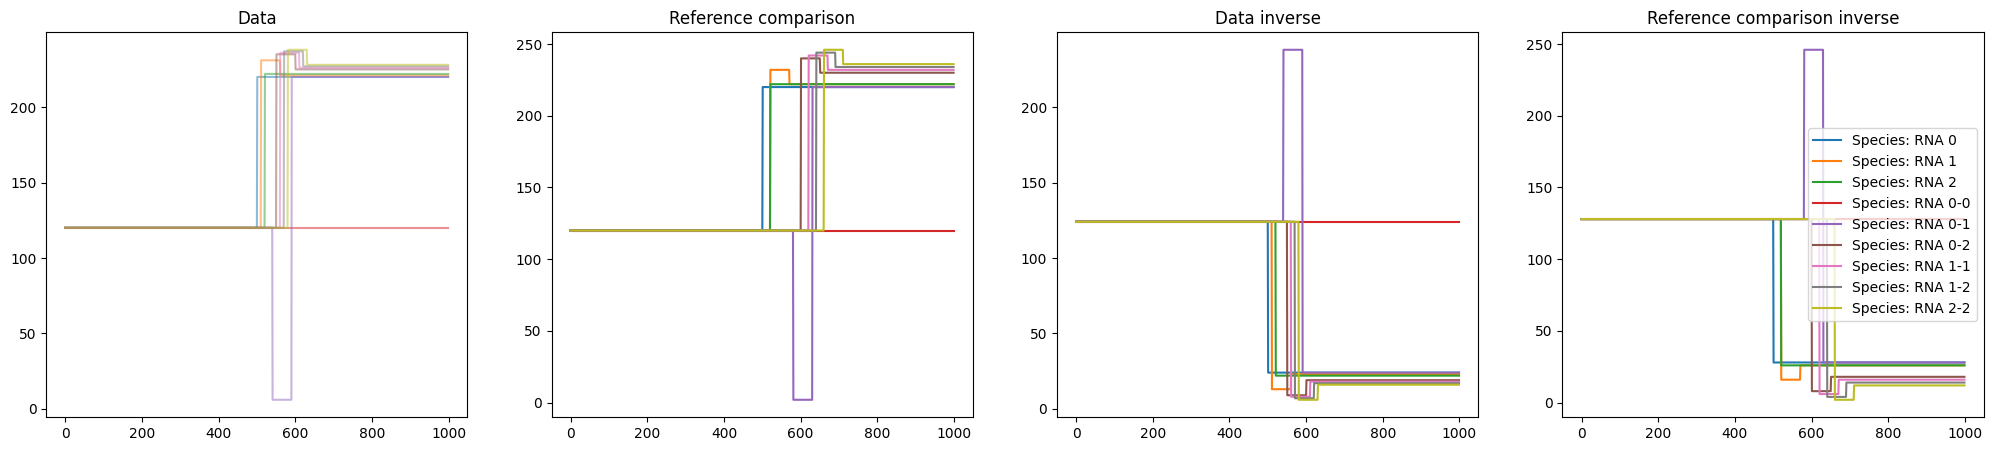

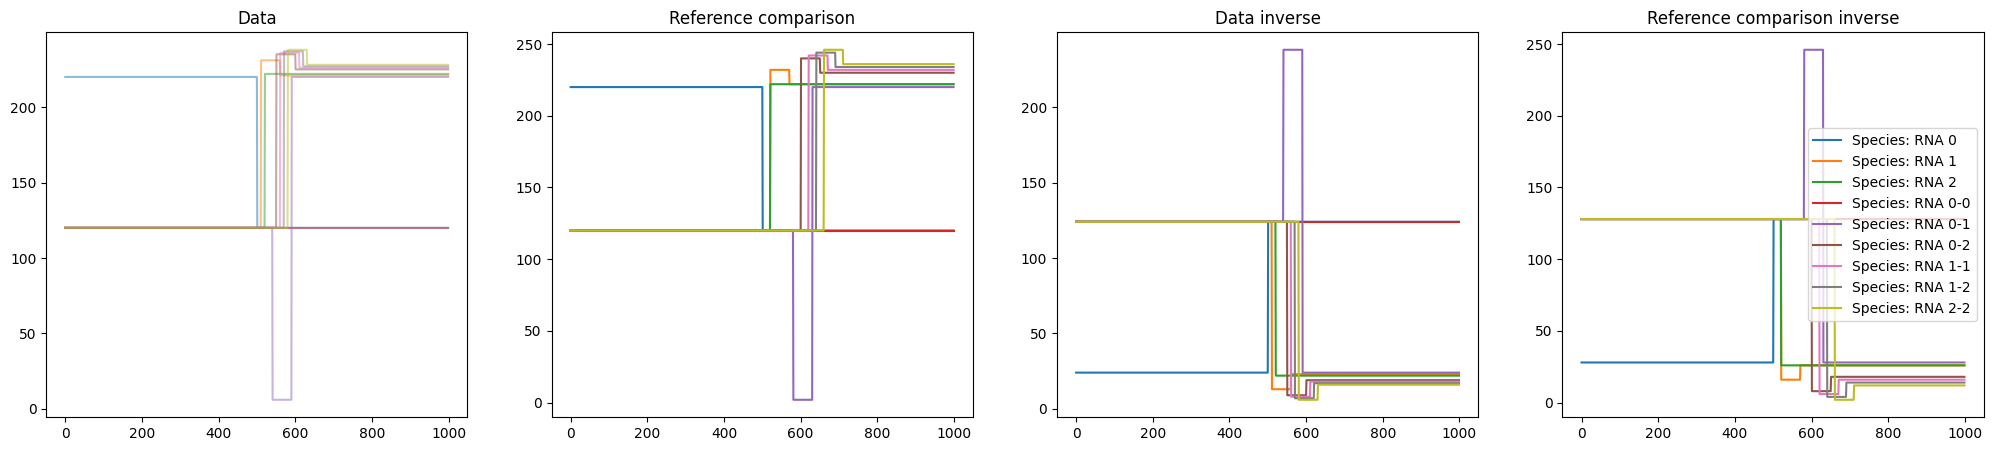

In [ ]:
for i in [0, 2]:
    if i == 0:
        print('1st row: Signal response in the same direction')
    else:
        print('2nd row: Signal respones in the inverse direction')
    plt.figure(figsize=(25,5))
    ax = plt.subplot(1,4,1)
    plt.plot(np.swapaxes(batch_data[i], 0, 1), alpha=0.5)
    plt.title('Data')
    ax = plt.subplot(1,4,2)
    plt.plot(np.swapaxes(batch_ref_data[i], 0, 1))
    plt.title('Reference comparison')
    ax = plt.subplot(1,4,3)
    plt.plot(np.swapaxes(batch_data[i+1], 0, 1))
    plt.title('Data inverse')
    ax = plt.subplot(1,4,4)
    plt.plot(np.swapaxes(batch_ref_data[i+1], 0, 1))
    plt.title('Reference comparison inverse')
    plt.legend(med_model.species)


# Examining analytics of this data

There are four possible ways a system can behave with a signal. The signal can be a rising or falling step function and the system's response may also be rising or falling. The precision, sensitivity, overshoot and time response must all be invariant to this. 

$$ Sensitivity = | \frac{(O_{peak} - O_1) / O_1}{(I_2 - I_1) / I_1} |$$

$$ Precision =  | \frac{(O_2 - O1)/O_1}{(I_2 - I_1) / I_1} |^{-1} $$

Precision and sensitivity - same for inverse response.

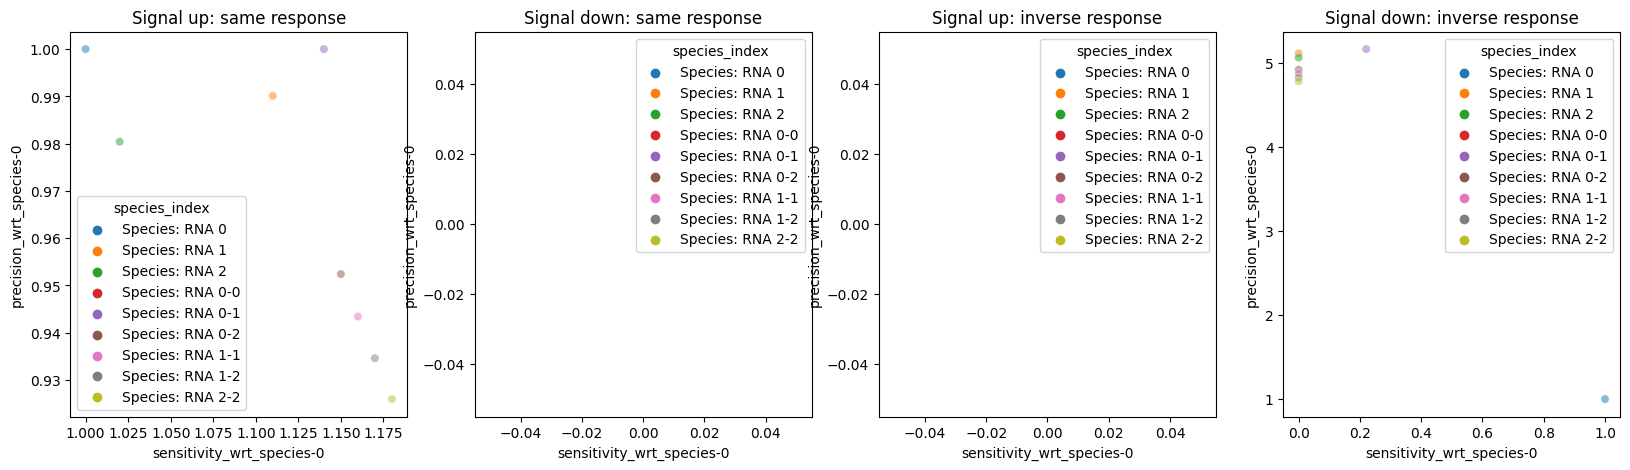

In [ ]:
plt.figure(figsize=(20,5))
for i in range(batch_data.shape[0]):
    ax = plt.subplot(1,4,i+1)
    sns.scatterplot(analytics_df[analytics_df['data_index'] == i], 
                    x='sensitivity_wrt_species-0', y='precision_wrt_species-0',
                    hue='species_index', alpha=0.5)
    plt.title(analytics_df[analytics_df['data_index'] == i]['data_category'].unique()[0])

Overshoot and time response: these will be as accurate as the resolution of the supplied time axis.

ValueError: x and y must be the same size

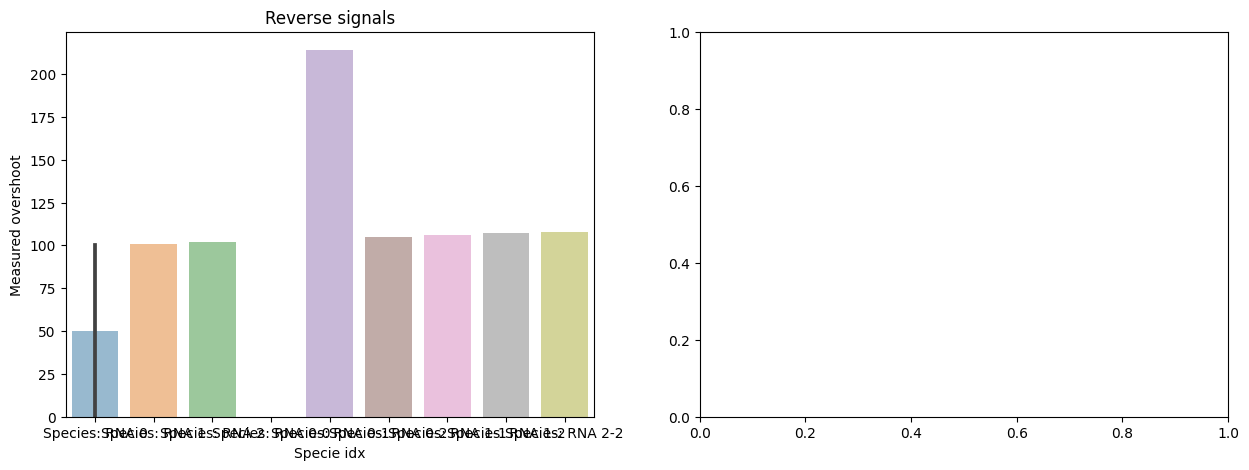

In [ ]:
plt.figure(figsize=(15,5))
ax = plt.subplot(1,2,1)
# sns.barplot(analytics_df, x='species_index', y='overshoot', alpha=0.5)
sns.barplot(analytics_df[(analytics_df['data_index'] == 1) | (analytics_df['data_index'] == 3)], x='species_index', y='overshoot', alpha=0.5)
plt.title('Reverse signals')
plt.xlabel('Specie idx')
plt.ylabel('Measured overshoot')

ax = plt.subplot(1,2,2)
plt.scatter(np.arange(len(med_model.species)), analytics['response_time_wrt_species-0'])
plt.xlabel('Specie idx')
plt.ylabel('Response time')

print('Expected overshoots: ', data.max(axis=1) - data[:, -1])
rts = {i: overshoot/2 + i for i in list(np.arange(len(med_model.species))) if i not in [0, 2, 3]}
rts.update({0: 0, 2: 0, 3: np.inf})
print('Expected response times: ', dict(sorted(rts.items())))